In [4]:
import json, yaml, requests
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

df = pd.read_csv(file_name)

train_size = 0.84
train_points = int(train_size*len(df))
train_df = df.iloc[:train_points]
test_df = df.iloc[train_points:]

time_col, target_col = train_df.columns[0], train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)
train_df[target_col] = train_df[target_col].astype(float)
train_data = train_df.values.tolist()

# Forecast dates (based on sample code)
forecast_dates = test_df[time_col].tolist()
# Load URL config
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)
protocol, host, port = url_dict['protocol'], url_dict['host'], url_dict['port']

models_to_run = {
    'Naive': {'type': 'darts_naive'},
    'ETS': {'type': 'darts_autoets'},
    'ARIMA': {'type': 'darts_autoarima'},
    'Deep Sybil': {'type': 'deepsybil', 'external_params': {
        'type': 'meta_wa',
        'scorers': ['mase', 'smape'],
        'params': {
            'preprocessors': [{'type': 'minmaxscaler'}],
            'base_models': [
                # {'type': 'darts_tsmixer'}
                {'type': 'darts_nhits'}
                
                ]
        }
    }},
}

forecast_results = {}
mase_scores      = {}

for label, model_type in models_to_run.items():
    # Build model request
    model_request = {
        'type': 'meta_wa',
        'scorers': ['mase', 'smape'],
        'params': {
            'preprocessors': [
                {'type': 'dartsimputer'},
                {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
                {'type': 'minmaxscaler'}
            ],
            'base_models': [model_type]
        }
    }

    api_json = {'data': train_data, 'model': model_request}
    train_url = f"{protocol}://{host}:{port}/train"
    response = requests.post(train_url, json=api_json, verify=False)
    model_output = response.json()['model']
    metrics = response.json()['metrics']
    # extract MASE
    for m in metrics:
        if m['type'] == 'mase':
            mase_scores[label] = m['value']
            break
    print(label," Got scores ",response.json()['metrics'])

    # Forecast
    forecast_url = f"{protocol}://{host}:{port}/forecast"
    forecast_input = {'model': model_output, 'data': forecast_dates}
    response = requests.post(forecast_url, json=forecast_input, verify=False)
    forecast_data = response.json()['data']
    forecast_df = pd.DataFrame(forecast_data, columns=[time_col, target_col])
    forecast_results[label] = forecast_df




C:\Users\saira\AppData\Local\Temp\ipykernel_23736\1216326758.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[time_col] = train_df[time_col].astype(str)
C:\Users\saira\AppData\Local\Temp\ipykernel_23736\1216326758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target_col] = train_df[target_col].astype(float)
c:\Users\saira\anaconda3\envs\sybil\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil.tempor.ai'

Naive  Got scores  [{'type': 'mase', 'value': 0.9999999999980891}, {'type': 'smape', 'value': 13.50598618170479}]


c:\Users\saira\anaconda3\envs\sybil\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\saira\anaconda3\envs\sybil\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


ETS  Got scores  [{'type': 'mase', 'value': 0.43840824824498376}, {'type': 'smape', 'value': 6.109995878219745}]


c:\Users\saira\anaconda3\envs\sybil\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\saira\anaconda3\envs\sybil\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


ARIMA  Got scores  [{'type': 'mase', 'value': 0.3707755885598707}, {'type': 'smape', 'value': 5.2011883006992905}]


c:\Users\saira\anaconda3\envs\sybil\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\saira\anaconda3\envs\sybil\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Deep Sybil  Got scores  [{'type': 'mase', 'value': 0.37326635723431806}, {'type': 'smape', 'value': 5.057471608326684}]


c:\Users\saira\anaconda3\envs\sybil\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


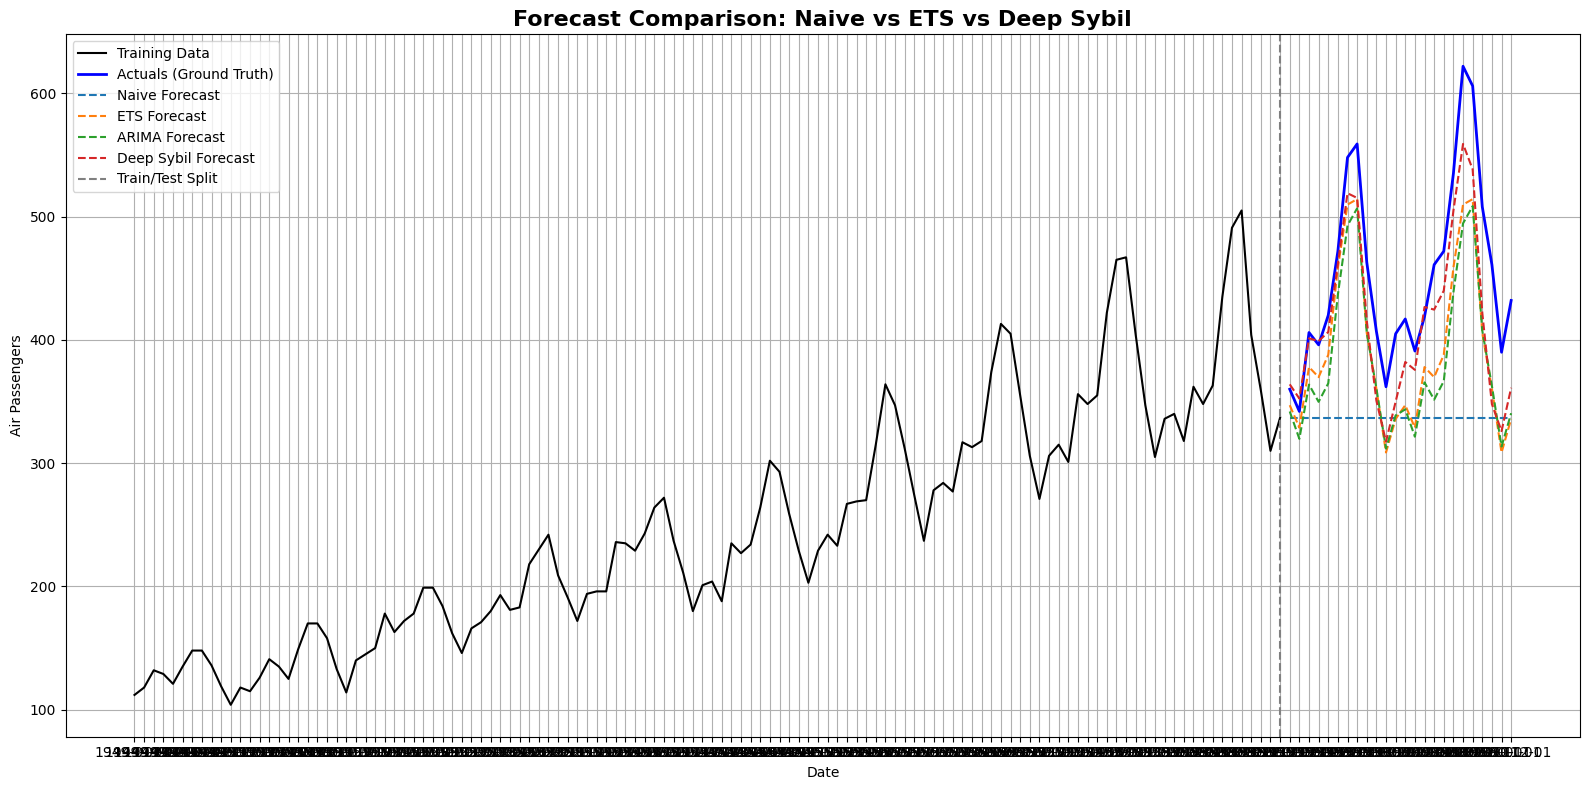


MASE scores by model:

     Model     MASE
     Naive 1.000000
       ETS 0.438408
     ARIMA 0.370776
Deep Sybil 0.373266


In [5]:
# PLOTTING
plt.figure(figsize=(16, 8))

# training and actuals in solid
plt.plot(train_df[time_col], train_df[target_col], label='Training Data', color='black', linestyle='solid')
plt.plot(test_df[time_col],  test_df[target_col],  label='Actuals (Ground Truth)', color='blue',   linestyle='solid', linewidth=2)

# forecasts in dashed
for label, fdf in forecast_results.items():
    plt.plot(fdf[time_col], fdf[target_col], label=f'{label} Forecast', linestyle='dashed')

plt.axvline(x=train_df[time_col].iloc[-1], color='gray', linestyle='--', label='Train/Test Split')
plt.title('Forecast Comparison: Naive vs ETS vs Deep Sybil', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Air Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MASE TABLE
mase_df = (
    pd.DataFrame.from_dict(mase_scores, orient='index', columns=['MASE'])
      .reset_index()
      .rename(columns={'index': 'Model'})
)
print("\nMASE scores by model:\n")
print(mase_df.to_string(index=False))